In [73]:
import numpy as np
import pandas as pd
from scipy.stats import norm, ttest_ind, poisson
from tqdm.auto import tqdm
import scipy
import matplotlib.pyplot as plt

def deltamethod(x_0, y_0, x_1, y_1):
    n_0 = y_0.shape[0]-1
    n_1 = y_0.shape[0]-1

    mean_x_0, var_x_0 = np.mean(x_0), np.var(x_0)
    mean_x_1, var_x_1 = np.mean(x_1), np.var(x_1)

    mean_y_0, var_y_0 = np.mean(y_0), np.var(y_0)
    mean_y_1, var_y_1 = np.mean(y_1), np.var(y_1)

    cov_0 = np.mean((x_0 - mean_x_0.reshape(-1, )) * (y_0 - mean_y_0.reshape(-1, )))
    cov_1 = np.mean((x_1 - mean_x_1.reshape(-1, )) * (y_1 - mean_y_1.reshape(-1, )))

    var_0 = var_x_0 / mean_y_0 ** 2 + var_y_0 * mean_x_0 ** 2 / mean_y_0 ** 4 - 2 * mean_x_0 / mean_y_0 ** 3 * cov_0
    var_1 = var_x_1 / mean_y_1 ** 2 + var_y_1 * mean_x_1 ** 2 / mean_y_1 ** 4 - 2 * mean_x_1 / mean_y_1 ** 3 * cov_1

    rto_0 = np.sum(x_0) / np.sum(y_0)
    rto_1 = np.sum(x_1) / np.sum(y_1)

    statistic = (rto_1 - rto_0) / np.sqrt(var_0 / n_0 + var_1 / n_1)
    pvalue = 2 * np.minimum(norm(0, 1).cdf(statistic), 1 - norm(0, 1).cdf(statistic))
    return pvalue


def linearization(x_0, y_0, x_1, y_1):
    k = x_0.sum() / y_0.sum()
    l_0 = x_0 - k * y_0
    l_1 = x_1 - k * y_1
    return l_0, l_1


def bootstrap_poisson(rto0, w0, rto1, w1, boot_it=500):
    """
    Пуассоновский бутстрап
    :param rto0: Рассчитанное ratio для левого сплита
    :param w0: Знаменатель rto0
    :param rto1: Рассчитанное ratio для правого сплита
    :param w1: Знаменатель rto1
    :param boot_it: количество бут итераций
    :return: pvalue
    """
    
    poisson_0 = poisson(1).rvs((boot_it, rto0.size)).astype(np.int64)
    poisson_1 = poisson(1).rvs((boot_it, rto1.size)).astype(np.int64)

    rto1 = np.matmul(rto1 * w1, poisson_1.T)

    w1 = np.matmul(w1, poisson_1.T)

    rto0 = np.matmul(rto0 * w0, poisson_0.T)
    w0 = np.matmul(w0, poisson_0.T)
    
    delta = rto1 / w1 - rto0 / w0
    
    positions = np.sum(delta < 0)

    pvalue = 2 * np.minimum(positions, boot_it - positions) / boot_it
    return pvalue

In [74]:
np.random.seed(5)
n = 10000
df = pd.DataFrame({
    'user_id': np.random.randint(low = 1, high = 5050, size = n),
    'session_id': np.random.randint(low = 1, high = 30, size = n),
    'variant': np.random.randint(low = 0, high = 2, size = n),
    'bill': np.random.randint(low = 10, high = 100, size = n)
})

def agg_totals(x):
    names = { 'revenue_amt': sum(x['bill']), 'session_cnt': x['session_cnt'].nunique() }
    return pd.Series(names)

df_ = df.groupby(['user_id','variant']).apply(agg_totals).reset_index()
display(df_)

,user_id,variant,revenue_amt,session_cnt
0,1,1,48,1
1,2,0,68,1
2,3,0,153,3
3,4,0,193,3
4,4,1,129,1
...,...,...,...,...
6366,5046,1,78,2
6367,5047,0,155,2
6368,5047,1,20,1
6369,5048,0,356,4


In [82]:
deltamethod(
    df_.revenue_amt[df_.variant == 0],
    df_.session_cnt[df_.variant == 0],
    df_.revenue_amt[df_.variant == 1],
    df_.session_cnt[df_.variant == 1]
)

0.3586708556870396

In [85]:
# Получим тоже самое, что и дм
l_0, l_1 = linearization(
    df_.revenue_amt[df_.variant == 0],
    df_.session_cnt[df_.variant == 0],
    df_.revenue_amt[df_.variant == 1],
    df_.session_cnt[df_.variant == 1]
)

ttest_ind(l_0, l_1, equal_var=False)

Ttest_indResult(statistic=0.9265395001626586, pvalue=0.3542007868896986)

In [86]:
# и приблизительно тоже самое, что и бутстрап
bootstrap_poisson(
    df_.revenue_amt[df_.variant == 0] / df_.session_cnt[df_.variant == 0],
    df_.session_cnt[df_.variant == 0],
    df_.revenue_amt[df_.variant == 1] / df_.session_cnt[df_.variant == 1],
    df_.session_cnt[df_.variant == 1]
)

0.348

In [87]:
# Интересный факт, что если использовать обычный т-тест и дм на одной случайной величине, то получим те же pvalue
p_dm = deltamethod(
    df_.revenue_amt[df_.variant == 0],
    np.repeat(1,len(df_.revenue_amt[df_.variant == 0])),
    df_.revenue_amt[df_.variant == 1],
    np.repeat(1,len(df_.revenue_amt[df_.variant == 1])),
)

p_t = ttest_ind(df_.revenue_amt[df_.variant == 0], df_.revenue_amt[df_.variant == 1])

print(p_dm, p_t[1])

0.8892413817436526 0.8888245057483422


In [39]:
pvals_lin = []
pvals_dm = []
pvals_boot = []
for i in range(0,100):
    n = len(df_)
    df_['variant'] = np.random.randint(low = 0, high = 2, size = n)
    l_0, l_1 = linearization(
        df_.revenue_amt[df_.variant == 0],
        df_.session_cnt[df_.variant == 0],
        df_.revenue_amt[df_.variant == 1],
        df_.session_cnt[df_.variant == 1]
    )
    p_lin = ttest_ind(l_0, l_1, equal_var=False)[1]
    p_dm = deltamethod(
        df_.revenue_amt[df_.variant == 0],
        df_.session_cnt[df_.variant == 0],
        df_.revenue_amt[df_.variant == 1],
        df_.session_cnt[df_.variant == 1]
    )
    p_boot = bootstrap_poisson(
        df_.revenue_amt[df_.variant == 0] / df_.session_cnt[df_.variant == 0],
        df_.session_cnt[df_.variant == 0],
        df_.revenue_amt[df_.variant == 1] / df_.session_cnt[df_.variant == 1],
        df_.session_cnt[df_.variant == 1]
    )
    pvals_lin.append(p_lin)
    pvals_dm.append(p_dm)
    pvals_boot.append(p_boot)
    


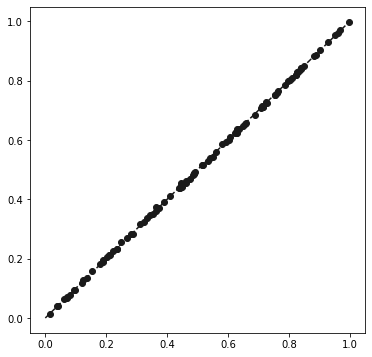

In [40]:
# Сравнение lin и dm
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(pvals_lin, pvals_dm, c=".1")
ax.plot([0, 1], [0, 1], ls="--", c=".1")

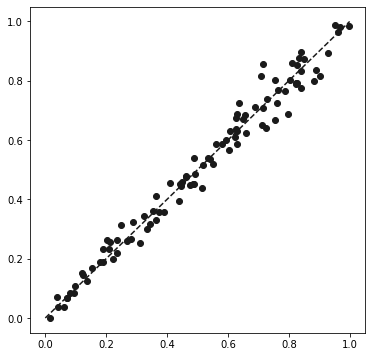

In [41]:
# Сравнение lin и boot
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(pvals_lin, pvals_boot, c=".1")
ax.plot([0, 1], [0, 1], ls="--", c=".1")

# Применяем бакеты

In [91]:
bucket_num = 500
buckets = np.repeat(np.arange(0, bucket_num), len(df_) // bucket_num)
reminder = np.arange(0, len(df_) - len(buckets))
buckets = np.append(buckets, reminder)
df_['bucket'] = buckets


# Агрегируем
def agg_totals(x):
    names = {
        'user_cnt': x['user_id'].nunique(),
        'revenue_amt': sum(x['revenue_amt']), 
        'session_cnt': x['session_cnt'].sum()
    }
    return pd.Series(names)

df_b = df_.groupby(["bucket", "variant"]).apply(agg_totals).reset_index()
# df_ = df_.groupby(["user_id", "bucket", "variant"]).apply(agg_totals).reset_index()

In [92]:
df_b

,bucket,variant,user_cnt,revenue_amt,session_cnt
0,0,0,9,985,17
1,0,1,4,310,4
2,1,0,7,398,9
3,1,1,6,488,8
4,2,0,4,326,6
...,...,...,...,...,...
995,497,1,5,487,7
996,498,0,3,441,6
997,498,1,9,892,16
998,499,0,4,470,9


# Немного поменяем функцию дельтаметода, чтобы корректно считать дисперсию

In [93]:
def deltamethod_bucketed(df_0, df_1, num_col, den_col, n_col):
    x_0 = np.array(df_0[num_col])
    x_1 = np.array(df_1[num_col])
    y_0 = np.array(df_0[den_col])
    y_1 = np.array(df_1[den_col])
    n_0 = np.array(df_0[n_col].sum())
    n_1 = np.array(df_1[n_col].sum())

    mean_x_0 = x_0.sum() / n_0
    mean_x_1 = x_1.sum() / n_1
    mean_y_0 = y_0.sum() / n_0
    mean_y_1 = y_1.sum() / n_1
    
    var_x_0 = np.sum(np.array([abs(a - mean_x_0)**2 for a in x_0])) / n_0
    var_x_1 = np.sum(np.array([abs(a - mean_x_1)**2 for a in x_1])) / n_1
    var_y_0 = np.sum(np.array([abs(a - mean_y_0)**2 for a in y_0])) / n_0
    var_y_1 = np.sum(np.array([abs(a - mean_y_1)**2 for a in y_1])) / n_1
    cov_0 = np.sum((x_0 - mean_x_0.reshape(-1, 1)) * (y_0 - mean_y_0.reshape(-1, 1)), axis=1) / n_0
    cov_1 = np.sum((x_1 - mean_x_1.reshape(-1, 1)) * (y_1 - mean_y_1.reshape(-1, 1)), axis=1) / n_1

    var_0 = var_x_0 / mean_y_0 ** 2 + var_y_0 * mean_x_0 ** 2 / mean_y_0 ** 4 - 2 * mean_x_0 / mean_y_0 ** 3 * cov_0
    var_1 = var_x_1 / mean_y_1 ** 2 + var_y_1 * mean_x_1 ** 2 / mean_y_1 ** 4 - 2 * mean_x_1 / mean_y_1 ** 3 * cov_1

    rto_0 = np.sum(x_0) / np.sum(y_0)
    rto_1 = np.sum(x_1) / np.sum(y_1)
    statistic = (rto_1 - rto_0) / np.sqrt(var_0 / n_0 + var_1 / n_1)

    pvalue = 2 * np.minimum(norm(0, 1).cdf(statistic), 1 - norm(0, 1).cdf(statistic))
    return pvalue[0]

## Сравниваем оригинальную выборку с бакетами

In [94]:
p_dm = deltamethod(
    df_.revenue_amt[df_.variant == 0],
    df_.session_cnt[df_.variant == 0],
    df_.revenue_amt[df_.variant == 1],
    df_.session_cnt[df_.variant == 1]
)

p_dm_bucketed = deltamethod_bucketed(
    df_0=df_b[df_b['variant'] == 0], 
    df_1=df_b[df_b['variant'] == 1], 
    num_col="revenue_amt", 
    den_col="session_cnt", 
    n_col="user_cnt"
)
print(p_dm, p_dm_bucketed)

0.3586708556870396 0.35347489103646834
